In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from ase import io, Atoms
from ase.io import gaussian
from ase import neighborlist
from ase.build import molecule
from scipy import sparse

from pathlib import Path

from collections import defaultdict
from molSimplify.Informatics.autocorrelation import*
from molSimplify.Classes.mol3D import *


In [19]:
atoms_basis = {
    24: "-Cr 0\nlanl2dz\nF 1 1.0\n1.941 1.0\n****\n\nCr\nlanl2dz\n\n",
    25: "-Mn 0\nlanl2dz\nF 1 1.0\n2.195 1.0\n****\n\nMn\nlanl2dz\n\n",
    26: "-Fe 0\nlanl2dz\nF 1 1.0\n2.462 1.0\n****\n\nFe\nlanl2dz\n\n",
    6: "-C 0\n6-31g(d)\n****\n",
    1: "-H 0\n6-31g(d,p)\n****\n",
    7: "-N 0\n6-31+g(d)\n****\n",
    8: "-O 0\n6-31+g(d)\n****\n",
    17: "-Cl 0\n6-31+g(d)\n****\n",
    9: "-F 0\n6-31+g(d)\n****\n",
    14: "-Si 0\n6-31g(d)\n****\n",
}

def write_com(atoms_obj, metal, filename_base, charge, multiplicity):
    atoms_obj.numbers[np.argmax(atoms_obj.numbers)] = metal
    filename = filename_base.split("/")[-1].strip(".com")
    print(filename)
    generated_add_sec = ""
    # order by atomic number so that the metal 'lanl2dz' spec can be provided at the end.
    for element in sorted(list(set(atoms_obj.numbers))):
        generated_add_sec+=atoms_basis[element]
    gaussian.write_gaussian_in(open(filename_base+".com", "w"), 
                                  atoms_obj, method='opt freq utpssh/gen scrf=(smd, solvent=h2o) pseudo=read',
                                 params={
                                     "chk": "{}.chk".format(filename),
                                     "mem": "100GB",
                                     "nprocshared": "40"
                                 },     
                               addsec=generated_add_sec,
                               charge=charge,
                               mult=multiplicity
                              )
    # For some reason ase adds a line between the coordinates and the basis set specifications
    # We need to delete that now, and we know from the above definitoin that the line preceding
    # the one with '-H 0' needs to be deleted, since we defined the basis sets so that 
    # the basis sets are ordered by atomic number
    with open(filename_base+".com", "r") as comfile2modify:
        lines = comfile2modify.readlines()
    newlines = []
    for idx, line in enumerate(lines):
        if idx==len(lines)-1:
            # handle the edge case so that the next bool not evaluated
            newlines.append(line)
        elif "-H 0" in lines[idx+1]:
            continue
        else:
            newlines.append(line)
    with open(filename_base+".com", "w") as final_com:
        for line in newlines:
            final_com.write(line)
            
def make_rac(this_mol, m_depth, l_depth, is_oct):
    properties = ['electronegativity', 'size', 'polarizability', 'nuclear_charge',]
                  #'topology', 'ident']
    feature_names = []
    mc_corrs = np.zeros(shape=(len(properties), (m_depth+1)))
    metal_idx = this_mol.findMetal()[0]
    mc_delta_metricz =  np.zeros(shape=(len(properties), m_depth))
    for idx, p in enumerate(properties):
        delta_list = list(np.asarray(atom_only_deltametric(this_mol, p, m_depth, metal_idx, oct=is_oct)).flatten())
        del delta_list[0]
        mc_corrs[idx] = np.asarray(atom_only_autocorrelation(this_mol, p, m_depth, metal_idx, oct=is_oct)).flatten()
        name_of_idx = ["MC-mult-{}-{}".format(p, x) for x in range(0, m_depth+1)]
        mc_delta_metricz[idx] = delta_list
        feature_names.extend(name_of_idx)
        name_of_idx_diff = ["MC-diff-{}-{}".format(p, x) for x in range(1, m_depth+1)]
        feature_names.extend(name_of_idx_diff)
        
    if is_oct:
        num_connectors = 6
    else:
        num_connectors = 5
    distances = []
    origin = this_mol.coordsvect()[metal_idx]
    for xyz in this_mol.coordsvect():
        distances.append(np.sqrt((xyz[0]-origin[0])**2+(xyz[1]-origin[1])**2+(xyz[2]-origin[2])**2))

    nearest_neighbours = np.argpartition(distances, num_connectors)
    nn = [x for x in nearest_neighbours[:num_connectors+1] if x != 0]
    rest_of_autoz = np.zeros(shape=(len(properties), l_depth+1))
    rest_of_deltas = np.zeros(shape=(len(properties), l_depth))
    for idx, p in enumerate(properties):
        rest_of_autoz[idx] = atom_only_autocorrelation(this_mol, p, l_depth, nn, oct=is_oct)
        rest_of_deltas[idx] = atom_only_deltametric(this_mol, p, l_depth, nn)[1:]
        name_of_idx = ["LC-mult-{}-{}".format(p, x) for x in range(0, l_depth+1)]
        name_of_idx_diff = ["LC-diff-{}-{}".format(p, x) for x in range(1, l_depth+1)]
        feature_names.extend(name_of_idx)
        
    
    rac_res = np.concatenate((mc_corrs, mc_delta_metricz, rest_of_autoz, rest_of_deltas),
                                axis=None)

    return rac_res, feature_names

In [3]:
output = os.popen("ls oh_func_catalysts/*final*").readlines()
output = [x.strip("\n") for x in output]
output[0]

single_charge = pickle.load(open("single_charge.p", "rb"))
single_charge_names = [x[0] for x in single_charge]
name2charge = defaultdict()
for name, charge in single_charge:
    name2charge[name] = charge


In [4]:
name2rac = defaultdict()

for xyz in output:
    if "water" in xyz:
        continue
    
    this_mol = mol3D() # mol3D instance
    this_mol.readfromxyz(xyz)
    split_filename = xyz.split("_")
    min_dist = float(split_filename[-1].strip(".xyz"))
    ccdc_label = split_filename[5]
    if ccdc_label not in single_charge_names:
        continue
    
    if min_dist<1.9:
        continue
    #print(xyz)
    for metal in ["Fe", "Mn", "Cr"]:
        alter_mol = mol3D()
        file_str = this_mol.coords()
        with open("try.xyz", "w") as f:
            f.write(file_str.replace("Fe", metal))
        alter_mol.readfromxyz("try.xyz")
        rac = make_rac(alter_mol, 3, 0, True)
        name = metal+"_"+split_filename[5]+"_"+split_filename[6]+"_"+split_filename[7]
        if "trans" in xyz:
            name+="_trans"
        else:
            name+="_cis"
        #print(name)
        name2rac[name] = (rac[0], xyz)
        #name2charge[ccdc_label] = single_charge_values


In [5]:
pickle.dump(name2rac, open("all_name.p", "wb"))

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm 

In [7]:
oer_desc_data = pickle.load(open("data_mc3_lc0.p", "rb"))

oer_desc_vals = []
racs = []
catalyst_names = []

for name in oer_desc_data:
    oer_desc_vals.append(oer_desc_data[name][0])
    racs.append(oer_desc_data[name][1])
    catalyst_names.append(name)
racs = np.asarray(racs)

new_racs = []
new_catalyst_names = []
paths2xyz = []
name2rac = pickle.load(open("all_name.p", "rb"))
for name in name2rac:
    #print(name)
    new_racs.append(name2rac[name][0])
    paths2xyz.append(name2rac[name][1])
    new_catalyst_names.append(name)
new_racs = np.asarray(new_racs)

In [8]:
sc = StandardScaler()
X_train, new_X = racs, new_racs
y_train = np.asarray(oer_desc_vals)
scaled_X_train = sc.fit_transform(X_train)
scaled_X_test = sc.fit_transform(new_X)
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, alpha=.01, n_restarts_optimizer=20)
gp.fit(scaled_X_train, y_train)
preds, stds = gp.predict(scaled_X_test, return_std=True)


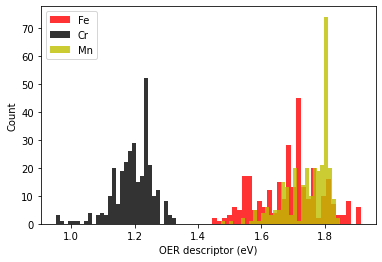

(array([ 62.,  55., 120.,  22.,   8.,   2.,   0.,   6.,  12.,   8.]),
 array([0.22821695, 0.28852837, 0.34883978, 0.40915119, 0.46946261,
        0.52977402, 0.59008543, 0.65039685, 0.71070826, 0.77101968,
        0.83133109]),
 <a list of 10 Patch objects>)

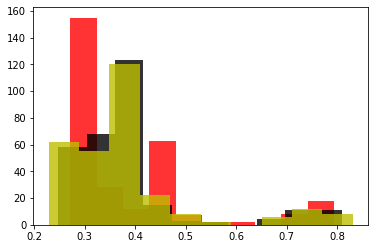

In [9]:
cr_preds = []
cr_errs = []
mn_preds = []
mn_errs = []
fe_preds = []
fe_errs = []

for name, pred, err in zip(new_catalyst_names, preds, stds):
    if "Fe" in name:
        fe_preds.append(pred)
        fe_errs.append(err)
    if "Mn" in name:
        mn_preds.append(pred)
        mn_errs.append(err)
    if "Cr" in name:
        cr_preds.append(pred)
        cr_errs.append(err)

plt.hist(fe_preds, alpha=0.8, color='r', bins=30, label='Fe')
plt.hist(cr_preds, alpha=0.8, color='k', bins=30, label='Cr')
plt.hist(mn_preds, alpha=0.8, color='y', bins=30, label='Mn')
plt.xlabel("OER descriptor (eV)")
plt.ylabel("Count")
plt.legend()
plt.savefig("histogram.png")
plt.show()
plt.hist(fe_errs, alpha=0.8, color='r')
plt.hist(cr_errs, alpha=0.8, color='k')
plt.hist(mn_errs, alpha=0.8, color='y')


In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [11]:
dim_reducer = PCA(n_components=0.95)
#dim_reducer = TSNE(n_components=2)
dim_reducer.fit(new_racs)
X_embedded = dim_reducer.fit_transform(new_racs)
X_embedded_old = dim_reducer.transform(racs)


found H: 77, oh_func_catalysts/save_as_opt_ECIJIJ_both_pyridine_final_1.9.xyz
0
Fe_ECIJIJ_both_pyridine_cis_OH3_HS
%mem=100GB

%chk=Fe_ECIJIJ_both_pyridine_cis_OH3_HS.chk

%nprocshared=40

#P opt freq utpssh/gen scrf=(smd, solvent=h2o) pseudo=read



Gaussian input prepared by ASE



2 6

Fe               -1.5774411000        0.2222557100       -1.2753808500

O                 0.4352618900        3.1620386000       -4.9340279000

O                -1.6485837200       -4.3401250500       -3.5888779300

N                -0.6981136800       -0.2950139500       -2.7764498800

N                -0.6400962600        2.2136821000       -1.8170753800

N                -0.0528457800        3.0881469700       -3.7916708300

N                -1.8407621700       -2.0192116500       -1.0710646200

N                -1.9371906600       -3.6630248200       -2.5854624000

C                -0.0418442000        0.6142119100       -3.5056714500

C                 0.6792117600        0.2496827300       -4.64


C                 3.3775990200        0.7426872800        3.1602092500

C                 4.6171558600        1.0537840100        3.7201678800

C                 5.6452092800        0.1186742700        3.6479382000

C                 5.4129206000       -1.1014421300        3.0204414300

C                 4.1522888200       -1.3556887800        2.4789114300

H                 2.5273952700        1.4336800700        3.1829057700

H                 4.7748682600        2.0203752400        4.2083633400

H                 6.6263207400        0.3405536600        4.0801924100

H                 6.2047978600       -1.8534484800        2.9505378500

H                 3.9039703300       -2.2950763200        1.9722490600

N                 0.0000000000        0.0000000000        0.0000000000

C                -0.0744016600       -0.7474416900       -1.1252844800

C                -1.2920216400       -1.2441594100       -1.5916631800

C                -2.4541444700       -0.9619607200       -0.880

found H: 85, oh_func_catalysts/save_as_opt_IVAGUJ_tet_final_pyridine_1.9.xyz
-2
Fe_IVAGUJ_tet_final_cis_OH3_HS
%mem=100GB

%chk=Fe_IVAGUJ_tet_final_cis_OH3_HS.chk

%nprocshared=40

#P opt freq utpssh/gen scrf=(smd, solvent=h2o) pseudo=read



Gaussian input prepared by ASE



0 6

Fe               -0.0281194400       -1.8793455200       -0.1746872200

C                -0.6547259700       -2.1595135400        2.7055305200

C                -0.3823426100       -1.4478727400        3.8974589300

H                -0.8355124100       -1.6418727500        4.8504386800

C                 0.5332947600       -0.4790867100        3.5807431700

H                 0.9808550400        0.2451463700        4.2334948300

C                 0.8461477000       -0.6507303700        2.2069303100

C                 1.9591779300       -0.1145151800        1.5513796700

C                 2.4794409100       -0.7035346300        0.3963317700

C                 3.7854582500       -0.5422598800       -0.1360399300

found H: 106, oh_func_catalysts/save_as_opt_KEDKIQ_tet_final_pyridine_1.9.xyz
-2
Fe_KEDKIQ_tet_final_cis_OH3_HS
%mem=100GB

%chk=Fe_KEDKIQ_tet_final_cis_OH3_HS.chk

%nprocshared=40

#P opt freq utpssh/gen scrf=(smd, solvent=h2o) pseudo=read



Gaussian input prepared by ASE



0 6

Fe               -0.2184484500       -1.7553534400       -0.7610270100

Si               -3.2343396400       -0.7047264000       -2.4826261900

N                -2.0314157000       -1.5472419700       -0.0212156200

N                 0.2844969900       -2.5073326600        0.8892624000

N                -0.3846783400       -0.9997611800       -2.5723588400

N                 1.5975824400       -2.0689533300       -1.1419311100

C                -4.1894653600        0.9056443100       -2.7684624300

C                 1.5584600100       -2.9315896900        0.9972080300

C                -1.4976165000       -0.5309328900       -3.1518630800

C                -3.7960435300       -1.4452600500        1.437059680

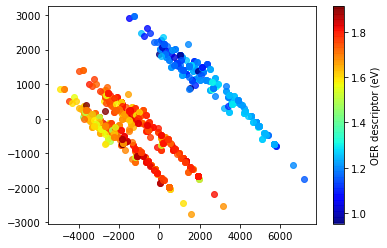

In [20]:
met2col = {
    "Fe": "r",
    "Cr": "gray",
    "Mn": "gold"
}
met2col_2 = {
    "Fe": "darkred",
    "Cr": "k",
    "Mn": "y"
}

for xy, name, err, path in zip(X_embedded, new_catalyst_names, preds, paths2xyz):
    #plt.plot(xy[0], xy[1], 'o', color=met2col[name[:2]], alpha=0.2)
    ccdc_label = name.split("_")[1]
    plt.scatter(xy[0], xy[1], c=err, vmin=min(preds), vmax=max(preds), alpha=0.8, cmap='jet')        
    
    
    # we save the xyz structures that are different                
    if name[:2]=="Fe" and xy[1]<-2000:
        #print(name, xy[1])
        #print(path)
        oh_base = Atoms(io.read(path))
        cutOff = neighborlist.natural_cutoffs(oh_base)
        neighborList = neighborlist.NeighborList(cutOff, self_interaction=False, bothways=True)
        neighborList.update(oh_base)
        neighbours = neighborList.get_neighbors(np.argmax(oh_base.numbers))
        for index in neighbours[0]:
            if oh_base.numbers[index]==8:
                o_nbrs = neighborList.get_neighbors(index)
                for o_nbr in o_nbrs[0]:
                    if oh_base.numbers[o_nbr]==1:
                        print('found H: {}, {}'.format(o_nbr, path))
                        h_index = o_nbr
                        break
        print(name2charge[ccdc_label])
        o_atoms = [x for idx, x in enumerate(oh_base.numbers) if idx!=o_nbr]
        o_pos = [x for idx, x in enumerate(oh_base.positions) if idx!=o_nbr]
        o_base = Atoms(o_atoms, o_pos)
        # these are M(III). Fe has LS/HS
        Path("coms/{}/OH3/HS".format(name)).mkdir(parents=True, exist_ok=True)
        Path("coms/{}/OH3/LS".format(name)).mkdir(parents=True, exist_ok=True)

        Path("coms/{}/OH3".format(name.replace("Fe", "Mn"))).mkdir(parents=True, exist_ok=True)
        Path("coms/{}/OH3".format(name.replace("Fe", "Cr"))).mkdir(parents=True, exist_ok=True)

        #os.mkdir("coms/{}/OH3".format(name))
        write_com(oh_base, 26, "coms/{}/OH3/HS/{}_OH3_HS".format(name, name),
                  name2charge[ccdc_label]+3-1, 6)
        write_com(oh_base, 26, "coms/{}/OH3/LS/{}_OH3_LS".format(name, name),
                  name2charge[ccdc_label]+3-1, 2)
        write_com(oh_base, 25, "coms/{}/OH3/{}_OH3_LS".format(name.replace("Fe","Mn"), name.replace("Fe", "Mn")),
                  name2charge[ccdc_label]+3-1, 5)
        write_com(oh_base, 24, "coms/{}/OH3/{}_OH3_LS".format(name.replace("Fe","Cr"), name.replace("Fe", "Cr")),
                  name2charge[ccdc_label]+3-1, 4)
        
        Path("coms/{}/OH4/HS".format(name)).mkdir(parents=True, exist_ok=True)
        Path("coms/{}/OH4/LS".format(name)).mkdir(parents=True, exist_ok=True)
        Path("coms/{}/OH4".format(name.replace("Fe", "Mn"))).mkdir(parents=True, exist_ok=True)
        Path("coms/{}/OH4".format(name.replace("Fe", "Cr"))).mkdir(parents=True, exist_ok=True)

        #os.mkdir("coms/{}/OH3".format(name))
        write_com(oh_base, 26, "coms/{}/OH4/HS/{}_OH4_HS".format(name, name),
                  name2charge[ccdc_label]+4-1, 5)
        write_com(oh_base, 26, "coms/{}/OH4/LS/{}_OH4_LS".format(name, name),
                  name2charge[ccdc_label]+4-1, 3)
        write_com(oh_base, 25, "coms/{}/OH4/{}_OH4_LS".format(name.replace("Fe","Mn"), name.replace("Fe", "Mn")),
                  name2charge[ccdc_label]+4-1, 4)
        write_com(oh_base, 24, "coms/{}/OH4/{}_OH4_LS".format(name.replace("Fe","Cr"), name.replace("Fe", "Cr")),
                  name2charge[ccdc_label]+4-1, 3)
        
        Path("coms/{}/OXO4/HS".format(name)).mkdir(parents=True, exist_ok=True)
        Path("coms/{}/OXO4/LS".format(name)).mkdir(parents=True, exist_ok=True)
        Path("coms/{}/OXO4".format(name.replace("Fe", "Mn"))).mkdir(parents=True, exist_ok=True)
        Path("coms/{}/OXO4".format(name.replace("Fe", "Cr"))).mkdir(parents=True, exist_ok=True)

        #os.mkdir("coms/{}/OH3".format(name))
        write_com(o_base, 26, "coms/{}/OXO4/HS/{}_OXO4_HS".format(name, name),
                  name2charge[ccdc_label]+4-2, 5)
        write_com(o_base, 26, "coms/{}/OXO4/LS/{}_OXO4_LS".format(name, name),
                  name2charge[ccdc_label]+4-2, 3)
        write_com(o_base, 25, "coms/{}/OXO4/{}_OXO4_LS".format(name.replace("Fe","Mn"), name.replace("Fe", "Mn")),
                  name2charge[ccdc_label]+4-2, 4)
        write_com(o_base, 24, "coms/{}/OXO4/{}_OXO4_LS".format(name.replace("Fe","Cr"), name.replace("Fe", "Cr")),
                  name2charge[ccdc_label]+4-2, 3)
        
        Path("coms/{}/OXO5".format(name)).mkdir(parents=True, exist_ok=True)
        Path("coms/{}/OXO5".format(name.replace("Fe", "Mn"))).mkdir(parents=True, exist_ok=True)
        Path("coms/{}/OXO5".format(name.replace("Fe", "Cr"))).mkdir(parents=True, exist_ok=True)

        #os.mkdir("coms/{}/OH3".format(name))
        write_com(o_base, 26, "coms/{}/OXO5/{}_OXO5_HS".format(name, name),
                  name2charge[ccdc_label]+5-2, 4)
        write_com(o_base, 25, "coms/{}/OXO5/{}_OXO5_LS".format(name.replace("Fe","Mn"), name.replace("Fe", "Mn")),
                  name2charge[ccdc_label]+5-2, 3)
        write_com(o_base, 24, "coms/{}/OXO5/{}_OXO5_LS".format(name.replace("Fe","Cr"), name.replace("Fe", "Cr")),
                  name2charge[ccdc_label]+5-2, 2)


plt.colorbar(label='OER descriptor (eV)')
